In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import glob

from nlld.nicermkf import MkfFileOps, readmkffile, define_nicerdetloc, define_nicerdetloc, define_nicerdet_cartxy
from nlld.mkfdiagnostics import *
from nlld.compare_mkfs_undershoots import *

%matplotlib inline 

# Input parameters 

In [2]:
# Orbit (night = 0, day = 1, both =2)
sunshine = 1

# Sun angle
sunAngLR = 95
sunAngUR = 100

# Moon angle
moonAngLR=0
moonAngUR=180

# Moon phase
moonphaseLR=0
moonphaseUR=1

# Bright earth
n_interval_bre = 9
brearth=np.append(np.linspace(45,125, n_interval_bre), 180)

# Sun clocking
n_interval_zunaz = 5
sunAz_1=np.linspace(0,180, n_interval_zunaz)-22.5
sunAz_2=np.linspace(-180,0, n_interval_zunaz)+22.5
sunAz = np.unique(np.append(sunAz_1,sunAz_2))

# under column
under = 'MPU_UNDER_COUNT'

# Number of detectors to drop
number_largestfpms_to_flag = 0

# Read the summary text files produced with compare_mkfs.py

In [3]:
df_summary_comparemkfs_median_all = pd.DataFrame()
corr_matrix_flat_all = pd.DataFrame()
nbd_det_on_percut = np.zeros(0)

# max undershoot to accept in a detector - if surpassed in any month from July 2023 to December 2024, remove
threshold_under = 1000

nbr_steps = 0
nbr_steps_withdata = 0

for ll in range(n_interval_bre):
    for jj in range(len(sunAz)-1):
        
        # Number of steps in the parameter space
        nbr_steps += 1

        # Name of files and folders where data sits
        directory_specific_cuts = ('ss' + str(sunshine) + '_sl' + str(sunAngLR) + '_su' + str(sunAngUR) + '_ml' + 
                                   str(moonAngLR) + '_mu' + str(moonAngUR) + '_mpl' + str(moonphaseLR) + '_mpu' + 
                                   str(moonphaseUR) + '_bel' + str(brearth[ll]) + '_beu' + str(brearth[ll+1]) + '_al' +
                                   str(sunAz[jj]) + '_au' + str(sunAz[jj+1]) + '_lff' + str(number_largestfpms_to_flag) + '_' + 
                                   under)
        
        summary_comparemkfs = glob.glob(directory_specific_cuts+'/*_clean_averageinfo.txt')
        
        # Check if the file exists
        if summary_comparemkfs:
            df_summary_comparemkfs = pd.read_csv(summary_comparemkfs[0], sep=" ", header=0, index_col=0)
            df_summary_comparemkfs_dropstdv = df_summary_comparemkfs[df_summary_comparemkfs.columns.drop(list(df_summary_comparemkfs.filter(regex='stdv')))]
            df_summary_comparemkfs_median = df_summary_comparemkfs_dropstdv[df_summary_comparemkfs_dropstdv.columns.drop(list(df_summary_comparemkfs_dropstdv.filter(regex='average')))]
            df_summary_comparemkfs_median = df_summary_comparemkfs_median[(df_summary_comparemkfs_median <= threshold_under).all(axis=1)]
            
            counts = df_summary_comparemkfs_median.index.value_counts()
            nbd_det_on_percut = np.append(nbd_det_on_percut, len(counts))
            
            nbr_steps_withdata += 1
            
        else:
            continue
            
        
        # Merging all medians in one dataframe
        df_summary_comparemkfs_median_all = pd.concat([df_summary_comparemkfs_median_all, df_summary_comparemkfs_median])

# Plot median distribution

In [4]:
# Create a series
summary_comparemkfs_median_all_series = df_summary_comparemkfs_median_all.stack()
summary_comparemkfs_median_all_series_log = np.log10(summary_comparemkfs_median_all_series)

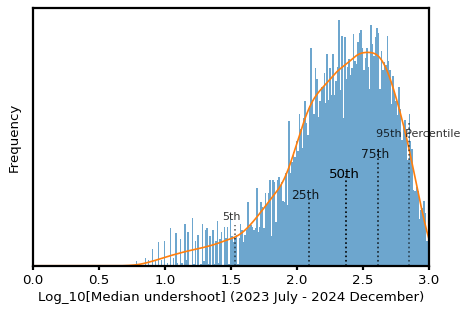

In [5]:
# Define the axes
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
ax.tick_params(axis='both', labelsize=12)
ax.set_yticklabels([])
ax.xaxis.offsetText.set_fontsize(12)
ax.tick_params(left = False)

# Plot histogram
summary_comparemkfs_median_all_series_log.plot(kind = "hist", density = True, alpha = 0.65, bins = 200) # change density to true, because KDE uses density
# Plot KDE
summary_comparemkfs_median_all_series_log.plot(kind = "kde")

ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlabel("Log_10[Median undershoot] (2023 July - 2024 December)", fontsize=12)

# Quantile lines
quant_5, quant_25, quant_50, quant_75, quant_95 = summary_comparemkfs_median_all_series_log.quantile(0.05), summary_comparemkfs_median_all_series_log.quantile(0.25), summary_comparemkfs_median_all_series_log.quantile(0.5), summary_comparemkfs_median_all_series_log.quantile(0.75), summary_comparemkfs_median_all_series_log.quantile(0.95)
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color='k')

# X
# Limit x range
x_start, x_end = 0, summary_comparemkfs_median_all_series_log.max()
ax.set_xlim(x_start, x_end)

# Annotations
ax.text(quant_5-.1, 0.22, "5th", size = 10, alpha = 0.8)
ax.text(quant_25-.13, 0.32, "25th", size = 11, alpha = 0.85)
ax.text(quant_50-.13, 0.42, "50th", size = 12, alpha = 1)
ax.text(quant_75-.13, 0.52, "75th", size = 11, alpha = 0.85)
ax.text(quant_95-.25, 0.62, "95th Percentile", size = 10, alpha =.8)

# Finishing touches
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(width=2)

fig.tight_layout()
plotName = 'undershoot_distribution_sa85-90_removedet_undershoots1000.png'
fig.savefig(plotName, format='png', dpi=200)
plt.show()

# Get some statistical properties of detectors 

In [6]:
counts = df_summary_comparemkfs_median_all.index.value_counts()
success_rate = counts/nbr_steps_withdata

### Create [x, y] coordinates of detectors based on the index, and merge with success rate

In [7]:
cart_coord_nicerdet_df = define_nicerdet_cartxy()

det_seccussrate_df = pd.merge(cart_coord_nicerdet_df, success_rate.to_frame('Success_rate'),
                              left_index=True, right_index=True)

# Plot a heat map of success rate

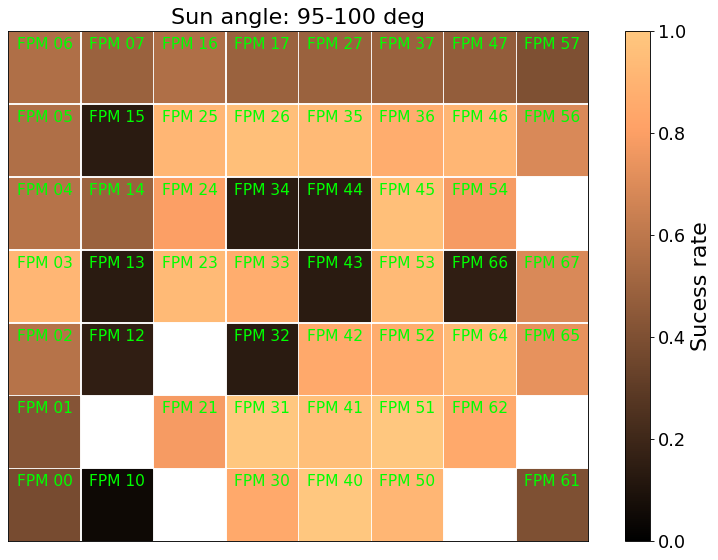

In [8]:
# Define the axes
fig, ax1 = plt.subplots(1, figsize=(11.7, 8.45), dpi=80, facecolor='w', edgecolor='k')
ax1.tick_params(axis='both', labelsize=8)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax1.xaxis.offsetText.set_fontsize(8)
textcolor = 'lime'

det_x = np.stack(det_seccussrate_df['Det_xy'].to_numpy())[:,0]
det_y = np.stack(det_seccussrate_df['Det_xy'].to_numpy())[:,1]

sc = ax1.scatter(det_x, det_y, c=det_seccussrate_df['Success_rate'], marker='s', s=4000, cmap='copper', vmin=0, vmax=1)
ax1.set_xlim(-0.5, 7.5)
ax1.set_ylim(-0.5, 6.5)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Sucess rate', fontsize=20)

plt.title('Sun angle: 95-100 deg', fontsize=20)

for ii, det_cart_coord in enumerate(det_seccussrate_df['Det_xy']):
    if str(det_seccussrate_df.index[ii])=='0':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 00', fontsize=14, color=textcolor)
    elif str(det_seccussrate_df.index[ii])=='1':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 01', fontsize=14, color=textcolor)
    elif str(det_seccussrate_df.index[ii])=='2':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 02', fontsize=14, color=textcolor)
    elif str(det_seccussrate_df.index[ii])=='3':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 03', fontsize=14, color=textcolor)
    elif str(det_seccussrate_df.index[ii])=='4':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 04', fontsize=14, color=textcolor)
    elif str(det_seccussrate_df.index[ii])=='5':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 05', fontsize=14, color=textcolor)
    elif str(det_seccussrate_df.index[ii])=='6':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 06', fontsize=14, color=textcolor)
    elif str(det_seccussrate_df.index[ii])=='7':
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 07', fontsize=14, color=textcolor)
    else:
        ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM '+str(det_seccussrate_df.index[ii]), fontsize=14, color=textcolor)

# Saving figure
plotName = 'example_detector_successrate.pdf'
fig.savefig(plotName, format='pdf', dpi=200)
plt.show()

# Let's try to create a movie of all sun_angles

In [9]:
# max undershoot to accept in a detector - if surpassed in any month from July 2023 to December 2024, remove    
threshold_under = 1000

def detector_statistics(sunshine=sunshine, sunAngLR=sunAngLR, sunAngUR=sunAngUR, moonAngLR=moonAngLR, 
                        moonAngUR=moonAngUR, moonphaseLR=moonphaseLR, moonphaseUR=moonphaseUR, 
                        brearthLR=45, brearthUR=180, timepostleak=True, under=under, 
                        largestfpms_to_flag=number_largestfpms_to_flag):
    
    # Sun clocking
    n_interval_zunaz = 5 # hard coded for now
    sunAz_1=np.linspace(0,180, n_interval_zunaz)-22.5
    sunAz_2=np.linspace(-180,0, n_interval_zunaz)+22.5
    sunAz = np.unique(np.append(sunAz_1,sunAz_2))
    
    # Important information
    df_summary_comparemkfs_median_all = pd.DataFrame()
    nbr_det_on_percut = np.zeros(0)

    nbr_steps = 0
    nbr_steps_withdata = 0


    for jj in range(len(sunAz)-1):

        # Number of steps in the parameter space
        nbr_steps += 1

        # Name of files and folders where data sits
        directory_specific_cuts = ('ss' + str(sunshine) + '_sl' + str(sunAngLR) + '_su' + str(sunAngUR) + '_ml' + 
                                   str(moonAngLR) + '_mu' + str(moonAngUR) + '_mpl' + str(moonphaseLR) + '_mpu' + 
                                   str(moonphaseUR) + '_bel' + str(brearthLR) + '_beu' + str(brearthUR) + '_al' +
                                   str(sunAz[jj]) + '_au' + str(sunAz[jj+1]) + '_lff' + str(number_largestfpms_to_flag) + '_' + 
                                   under)

        summary_comparemkfs = glob.glob(directory_specific_cuts+'/*_clean_averageinfo.txt')

        # Check if the file exists
        if summary_comparemkfs:
            df_summary_comparemkfs = pd.read_csv(summary_comparemkfs[0], sep=" ", header=0, index_col=0)
            df_summary_comparemkfs_dropstdv = df_summary_comparemkfs[df_summary_comparemkfs.columns.drop(list(df_summary_comparemkfs.filter(regex='stdv')))]
            df_summary_comparemkfs_median = df_summary_comparemkfs_dropstdv[df_summary_comparemkfs_dropstdv.columns.drop(list(df_summary_comparemkfs_dropstdv.filter(regex='average')))]
            df_summary_comparemkfs_median = df_summary_comparemkfs_median[(df_summary_comparemkfs_median <= threshold_under).all(axis=1)]
            
            counts = df_summary_comparemkfs_median.index.value_counts()
            nbr_det_on_percut = np.append(nbr_det_on_percut, len(counts))

            nbr_steps_withdata += 1

        else:
            #logger.info('No summary for these cuts {}'.format(directory_specific_cuts))
            continue

        # Merging all medians in one dataframe
        df_summary_comparemkfs_median_all = pd.concat([df_summary_comparemkfs_median_all, df_summary_comparemkfs_median])
        
    return df_summary_comparemkfs_median_all, nbr_steps_withdata

# Create the movie

In [10]:
# Creating a n*2 array of bright earth, and passing them to frames to animate
# If a parameter cut does not have any data, the animate function will return an empty frame
# to avoid that, let's find out which bright-earth angle cuts had data
brightearth_range_tmp = np.array((brearth[:-1] , brearth[1:])).T
brightearth_range = np.empty((0, 2), dtype=float)

for ii in range(len(brightearth_range_tmp)):
    
    brightearth_ll, brightearth_ul = brightearth_range_tmp[ii]
    df_summary_comparemkfs_median_all, nbr_steps_withdata = detector_statistics(brearthLR=brightearth_ll, brearthUR=brightearth_ul)
    
    if df_summary_comparemkfs_median_all.empty:
        continue
    else:
        brightearth_range = np.vstack((brightearth_range, brightearth_range_tmp[ii]))

In [11]:
fig, ax1 = plt.subplots(figsize=(11.7, 8.45), facecolor='w', edgecolor='k')

# Function to provide to funcAnimation
def animate(brightearth_range):

    # Defining our plot properties
    # Define the axes
    fig.clf()
    ax1 = fig.add_subplot(111, aspect='equal', autoscale_on=False)
    ax1.tick_params(axis='both', labelsize=8)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
    ax1.xaxis.offsetText.set_fontsize(8)
    textcolor = 'lime'
    
    # Breaking up the brightearth into lower-limit and upper-limit
    brightearth_ll, brightearth_ul = brightearth_range
    
    # Filtering data for given bright earth range
    df_summary_comparemkfs_median_all, nbr_steps_withdata = detector_statistics(brearthLR=brightearth_ll, brearthUR=brightearth_ul)
    
    # Deriving the essential statistical property - detector success rate
    counts = df_summary_comparemkfs_median_all.index.value_counts()
    success_rate = counts/nbr_steps_withdata
    #print(success_rate)
    
    # Merging the success rate with the detector dataframe
    det_seccussrate_df = pd.merge(cart_coord_nicerdet_df, success_rate.to_frame('Success_rate'), 
                                  left_index=True, right_index=True)
    
    if det_seccussrate_df.empty:
        return
    
    det_x = np.stack(det_seccussrate_df['Det_xy'].to_numpy())[:,0]
    det_y = np.stack(det_seccussrate_df['Det_xy'].to_numpy())[:,1]

    # Creating the plots
    sc = ax1.scatter(det_x, det_y, c=det_seccussrate_df['Success_rate'], marker='s', s=4000, cmap='copper', vmin=0, vmax=1)
    ax1.set_xlim(-0.5, 7.5)
    ax1.set_ylim(-0.5, 6.5)

    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Sucess rate', fontsize=20)
    
    plt.title('SA: 95-100 deg; BEA: '+str(brightearth_ll)+'-'+str(brightearth_ul)+' deg', fontsize=20)

    for ii, det_cart_coord in enumerate(det_seccussrate_df['Det_xy']):
        if str(det_seccussrate_df.index[ii])=='0':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 00', fontsize=14, color=textcolor)
        elif str(det_seccussrate_df.index[ii])=='1':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 01', fontsize=14, color=textcolor)
        elif str(det_seccussrate_df.index[ii])=='2':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 02', fontsize=14, color=textcolor)
        elif str(det_seccussrate_df.index[ii])=='3':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 03', fontsize=14, color=textcolor)
        elif str(det_seccussrate_df.index[ii])=='4':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 04', fontsize=14, color=textcolor)
        elif str(det_seccussrate_df.index[ii])=='5':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 05', fontsize=14, color=textcolor)
        elif str(det_seccussrate_df.index[ii])=='6':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 06', fontsize=14, color=textcolor)
        elif str(det_seccussrate_df.index[ii])=='7':
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM 07', fontsize=14, color=textcolor)
        else:
            ax1.text(det_cart_coord[0]-0.38, det_cart_coord[1]+0.25, 'FPM '+str(det_seccussrate_df.index[ii]), fontsize=14, color=textcolor)

# calling the animation function
anim = animation.FuncAnimation(fig, animate, frames=brightearth_range, blit=False)
anim.save('example_detector_successrate_loopbea.mp4', writer = 'ffmpeg', fps = 0.5)
plt.close()
# Finished creating the movie
###########################################################################

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 11.7 x 8.45 to 11.694444444444445 x 8.444444444444445
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 842x608 -pix_fmt rgba -framerate 0.5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y example_detector_successrate_loopbea.mp4
